In [42]:
#Import libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
#Get the stock quote
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-04-05')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.994907
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.268970
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.838169
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.380054
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.296970
...,...,...,...,...,...,...
2020-03-30,255.520004,249.399994,250.740005,254.809998,41994100.0,254.809998
2020-03-31,262.489990,252.000000,255.600006,254.289993,49250500.0,254.289993
2020-04-01,248.720001,239.130005,246.500000,240.910004,44054600.0,240.910004


In [4]:
#Get the number of columns and rows
df.shape

(2077, 6)

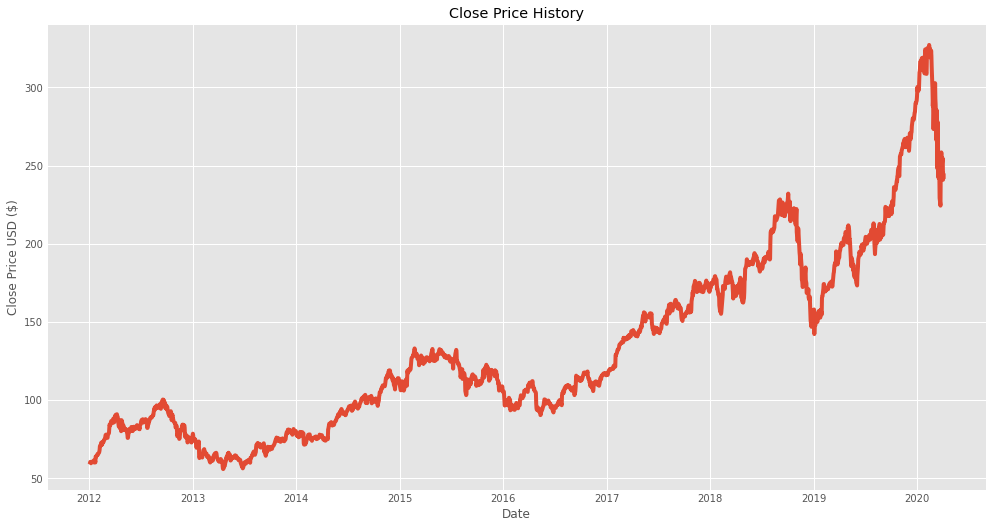

In [43]:
#Visualize the closing price
plt.figure(figsize=(15, 8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

In [18]:
#Create a new dataframe with only the close column
data = df.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

1662

In [19]:
#Create test and train sets
train = data[:training_data_len]
valid = data[training_data_len:]

In [20]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01089548],
       [0.01205872],
       [0.01447467],
       ...,
       [0.6820677 ],
       [0.6968792 ],
       [0.68390993]])

In [21]:
#Create the training dataset
#train_data = scaled_data[0:training_data_len, :]
#Split the data into x_train and y_train
x_train = []
y_train = []

for i in range(60, len(train)):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

In [22]:
#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [23]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1602, 60, 1)

In [24]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [25]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
#Train the model
#model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
1602/1602 [==============================] - 186s 116ms/step - loss: 5.3478e-04


In [27]:
#Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]
#Create the x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [28]:
#Convert the data to numpy array
x_test = np.array(x_test)

In [29]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [30]:
#Get the models predicted values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [31]:
#Get the root mean squared error (RMSE)
rmse=np.sqrt(np.mean((predictions - y_test) ** 2))
rmse

9.114254083713378

<ipython-input-44-22deddd72cf7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


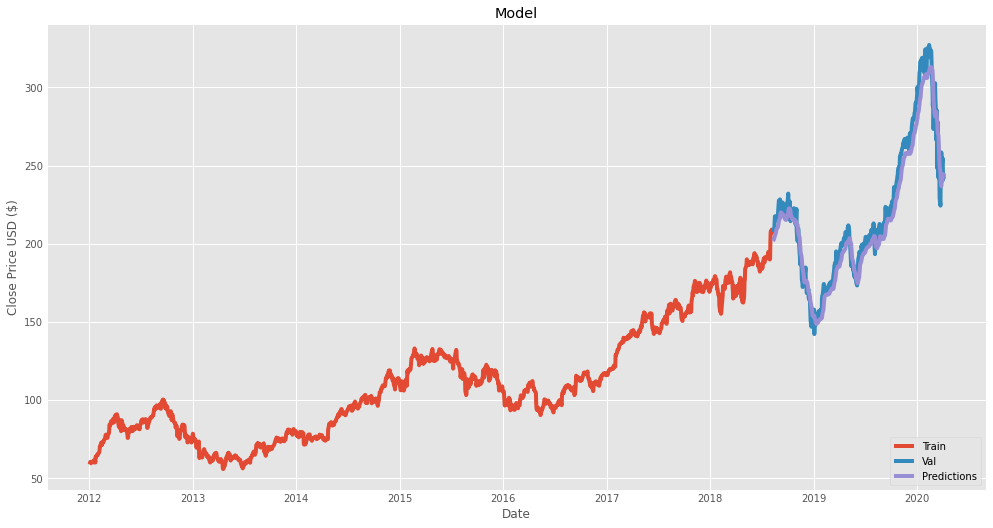

In [44]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions
#Visualize the data
plt.figure(figsize=(15, 8))
plt.title("Model")
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [33]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-08-10,207.529999,201.780380
2018-08-13,208.869995,202.563278
2018-08-14,209.750000,203.187576
2018-08-15,210.240005,203.757294
2018-08-16,213.320007,204.286911
...,...,...
2020-03-30,254.809998,240.434753
2020-03-31,254.289993,242.547226
2020-04-01,240.910004,244.502457


In [53]:
#Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-04-05')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get the last 60 days closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#Scale the data
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
X_test.append(last_60_days_scaled)
#Convert the X_test to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[242.5592]]


In [51]:
apple_quote_predicted = web.DataReader('AAPL', data_source='yahoo', start='2020-04-06', end='2020-04-06')
print(apple_quote_predicted['Close'])

Date
2020-04-06    262.470001
Name: Close, dtype: float64
